# **Binary  Classification**

# Table of contents
- Introduction
- EDA and Data cleaning
 - Importing libraries
 - Loading data
 - Overview
 - Distribution of the target variable
 - Concatenating train and test sets
 - Infinite values
 - Missing data overview
 - Correlation matrix
 - Handling outliers
- Feature Engineering
- Preprocessing and Baseline Modelling
 - Creating train-validation splits
 - Baseline Models from PyCaret
- Hyperparameter tuning and evaluating
- Submission and suggestions for improvement

# Introduction

The tasks are:
1. to analyze and characterize the customer portfolio of the organization
2. to build a basic bankruptcy forecasting model that approves at least 35% of clients in case of bankruptcy among approved ones no more than 15%, i.e. we need at least 35% precision and 85% recall of the model.
3. prepare recommendations and proposals for changing the feature space, using external data and other development of the base model.

# EDA and Data Cleaning

## Importing libraries

In [1]:
!pip install pycaret --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydocstyle 6.2.3 requires importlib-metadata<5.0.0,>=2.0.0; python_version < "3.8", but you have importlib-metadata 6.1.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
ibis-framework 2.1.1 requires importlib-metadata<5,>=4; python_version < "3.8", but you have importlib-metadata 6.1.0 which is incompatible.
flake8 5.0.4 requires importlib-metadata<4.3,>=1.1.0; python_version < "3.8", but you have importlib-metadata 6.1.0 which is incompatible.
cmudict 1.0.13 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 6.1.0 which is incompatible.


In [2]:
#basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  # display all columns
from scipy.stats import zscore
import scipy.stats as st

# Sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

# Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from pycaret.classification import *
from catboost import CatBoostClassifier


## Loading data

In [3]:
# Load the data into a Pandas DataFrame
test = pd.read_csv('/kaggle/input/all-reject/all_reject_data.csv')
train = pd.read_csv('/kaggle/input/train-data/new_training_data_31_08_2022.csv')
print(test.shape, train.shape)

(106511, 74) (42529, 75)


## Overview

In [4]:
train.head(2)

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,4.0,36458.0,3.0,0.0,0.0,18000.0,1.0,8458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.0,0.067308,0.0,0.009615,NaN,0.000000,31.566929,8.015748,0.228346,0.228346,0.028487,127.0,0.0,0.0,0.0,0.0,0.875,289.0,1.0,2.0,115.0,1.0,1.0,32.0,1.0,1.0,5.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,39.0,1902599.0,34.0,0.0,0.0,627578.0,33.0,583578.0,22.0,0.0,0.0,583578.0,14.0,348778.0,5.0,0.0,348778.0,0.794872,NaN,0.0,0.0,0.948052,0.0,0.714286,0.0,0.246753,0.322222,0.322222,0.000000,0.000000,0.000000,90.0,0.0,0.0,0.0,0.0,0.000,3.0,4.0,7.0,78.0,4.0,1.0,36.0,2.0,1.0,78.0,2.0,1.0,36.0,0.0,0.0,62.0,0.0,0.0,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0


In [5]:
test.head(2)

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
0,4,35.0,903.0,44683.0,0.0,43335.0,3.0,0.0,0.0,3500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.000000,NaN,0.00000,NaN,0.00000,120.00,0.0,0.0,0.0,NaN,3.0,0.0,0.0,0.022222,0.022222,0.955556,1348.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056551
1,6,32.0,4.0,0.0,0.0,1.0,31.0,361.0,0.0,403828.0,27.0,333828.0,187.0,0.0,0.0,333828.0,16.0,285828.0,23.0,0.0,0.0,285828.0,14.0,241828.0,6.0,0.0,241828.0,0.2375,NaN,0.0,0.0,0.545918,0.0,0.09949,0.0,0.05102,0.24,0.0,0.0,0.0,NaN,450.0,0.0,0.0,0.000000,0.000000,0.000000,4.0,3.0,2.0,445.0,1.0,0.0,30.0,1.0,2.0,240.0,0.0,0.0,27.0,0.0,0.0,57.0,0.0,0.0,16.0,0.0,0.0,35.0,0.0,0.0,14.0,0.0,NaN


In [6]:
# View summary statistics of the features
train.describe()

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,overdue_loans_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,overdue_loans_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_overdue_loans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
count,42529.000000,42529.000000,42529.000000,42529.000000,42520.000000,42520.000000,42529.000000,42529.000000,42529.000000,4.252900e+04,42529.000000,4.252900e+04,42529.000000,42529.000000,42529.0,4.252900e+04,42529.000000,4.252900e+04,42529.000000,42529.000000,42529.0,4.252900e+04,42529.000000,4.252900e+04,42529.000000,42529.000000,4.252900e+04,42497.000000,35685.0,42529.000000,42506.000000,42529.000000,42311.000000,42529.000000,42136.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,39968.000000,42529.000000,42520.000000,42520.000000,42520.000000,42520.000000,42520.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,3.972900e+04,42529.000000
mean,16848.107644,34.810083,10.635731,127.219074,0.341816,208.410136,20.514026,59.126384,0.601096,2.732486e+05,17.978697,4.341582e+05,41.251428,0.333772,0.0,2.630186e+05,15.395025,2.517135e+05,17.808178,0.196572,0.0,2.244234e+05,10.907687,1.524075e+05,3.656093,0.050083,1.444739e+05,0.664484,0.0,0.010133,0.006037,0.765207,0.005459,0.502247,0.003209,0.251325,6.131376,1.259617,0.360089,0.121117,0.235310,96.074914,0.261557,0.000800,0.000562,0.000424,0.020464,80.727856,3.126243,5.435562,85.083331,2.048508,1.192598,17.227351,0.792941,1.168614,66.454302,0.717581,0.557667,16.690211,0.138611,0.412401,38.021162,0.132827,0.186743,15.072774,0.032307,0.170284,16.744668,0.031414,0.099462,10.775824,105.647511,NaN,0.277458
std,10120.477450,8.824184,75.480643,2343.824022,13.084530,2694.463251,14.096084,93.770528,1.677791,2.572130e+05,12.962893,7.546497e+05,53.450976,1.126719,0.0,2.502506e+05,11.371042,3.418103e+05,21.240575,0.733526,0.0,2.042761e+05,8.590182,2.152385e+05,5.694563,0.336283,1.371331e+05,0.270511,0.0,0.030389,0.026586,0.237140,0.022691,0.257296,0.022702,0.183546,10.100164,3.376396,1.240212,0.464253,0.371458,120.402188,0.434042,0.014339,0.010849,0.009543,0.108893,1762.085559,3.359941,7.669688,116.720976,2.211903,1.703506,12.268475,1.327016,2.459338,70.279783,1.199907,1.074479,12.303613,0.523028,1.181154,35.370090,0.501096,0.544115,11.205629,0.259851,0.600797,15.945144,0.248208,0.380749,8.509719,36.631149,NaN,0.447750
min,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [7]:
# Find columns with only one unique value
unique_counts = train.nunique()
to_drop = [col for col in unique_counts.index if unique_counts[col] == 1]

# Drop columns with only one unique value
train = train.drop(columns=to_drop)
test = test.drop(columns=to_drop)

In [8]:
# Get the data types of all columns
dtypes = train.dtypes
# Count the number of categorical columns
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
print("Number of categorical columns:", len(categorical_cols))
# Print the number of categorical columns
numerical_cols = train.select_dtypes(include=['float', 'int']).columns
print("Number of numerical columns:", len(numerical_cols))

Number of categorical columns: 0
Number of numerical columns: 72


In [9]:
for col in train.columns:
    unique_vals = train[col].nunique()
    print(f"{col}: {unique_vals} unique values")

Unnamed: 0: 35685 unique values
age: 58 unique values
lastcredit: 381 unique values
time_to_lastcredit_closeddt: 401 unique values
close_loan_median: 104 unique values
open_loan_median: 634 unique values
is_active_100: 111 unique values
isnt_active_100: 629 unique values
is_lost_100: 29 unique values
micro_loans_active_100: 34620 unique values
is_active_12: 98 unique values
open_sum_12: 36354 unique values
isnt_active_12: 442 unique values
is_lost_12: 25 unique values
micro_loans_active_12: 34094 unique values
is_active_3: 88 unique values
open_sum_3: 33282 unique values
isnt_active_3: 204 unique values
is_lost_3: 17 unique values
micro_loans_active_3: 32620 unique values
is_active_1: 68 unique values
open_sum_1: 27443 unique values
isnt_active_1: 73 unique values
is_lost_1: 12 unique values
micro_loans_active_1: 27159 unique values
ratio_all_microloans_3_to_12: 6852 unique values
ratio_history_100: 1163 unique values
ratio_history_12: 790 unique values
fraction_last_x_12: 7133 unique 

Even though there are some features in the dataset that occur less than 10times, based on the feature description they should not be considered categorical, since they represent values or quantities

In [10]:
features_list = numerical_cols[:-1]
features_list

Index(['Unnamed: 0', 'age', 'lastcredit', 'time_to_lastcredit_closeddt',
       'close_loan_median', 'open_loan_median', 'is_active_100',
       'isnt_active_100', 'is_lost_100', 'micro_loans_active_100',
       'is_active_12', 'open_sum_12', 'isnt_active_12', 'is_lost_12',
       'micro_loans_active_12', 'is_active_3', 'open_sum_3', 'isnt_active_3',
       'is_lost_3', 'micro_loans_active_3', 'is_active_1', 'open_sum_1',
       'isnt_active_1', 'is_lost_1', 'micro_loans_active_1',
       'ratio_all_microloans_3_to_12', 'ratio_history_100', 'ratio_history_12',
       'fraction_last_x_12', 'ratio_history_3', 'fraction_last_x_3',
       'ratio_history_1', 'fraction_last_x_1', 'mean_delay_100_with_lag',
       'mean_delay_12_with_lag', 'mean_delay_3_with_lag',
       'mean_delay_1_with_lag', 'ratio_mean_delay_3_to_12',
       'count_all_credits', 'ratio_pattern_len_to_pattern_1',
       'ratio_pattern_len_to_pattern_2', 'ratio_pattern_len_to_pattern_3',
       'ratio_pattern_len_to_patter

## Distribution of the target variable

In [11]:
summary = train["target"].value_counts(normalize = True)
print('Distribution of the target variable:', summary)

Distribution of the target variable: 0.0    0.722542
1.0    0.277458
Name: target, dtype: float64


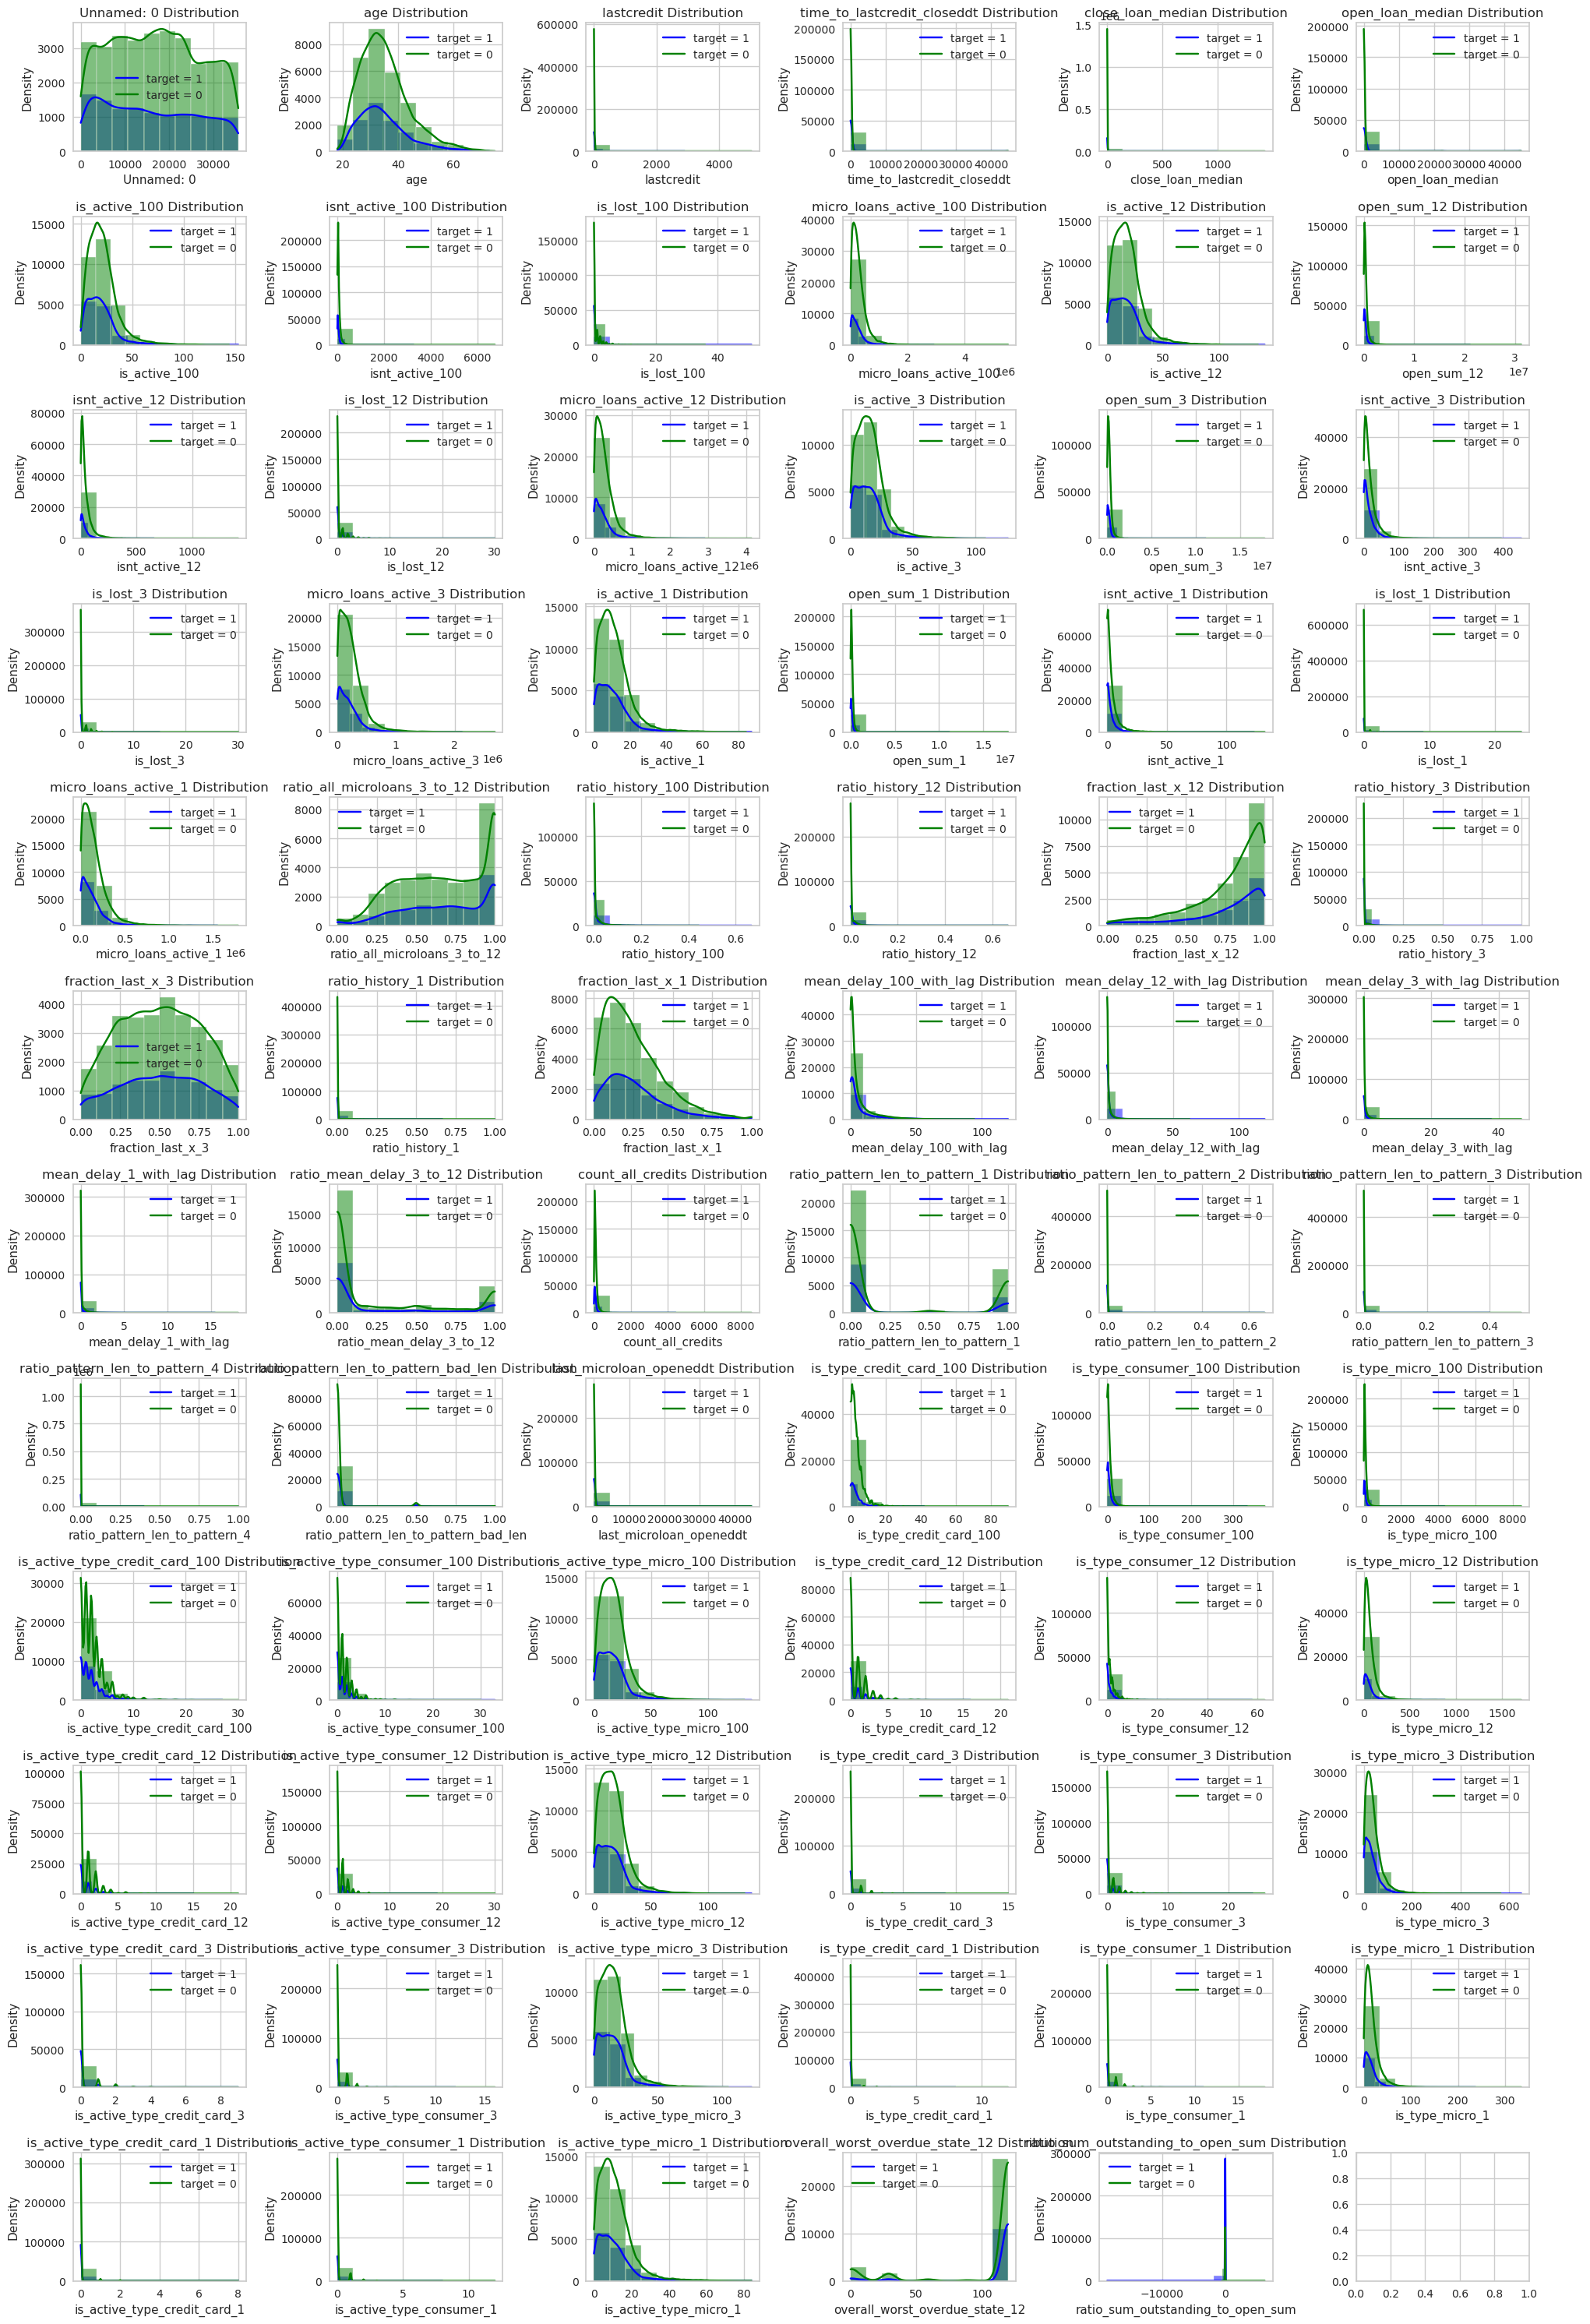

In [12]:
def compare_multifeature_target_distribution(dataframe, target_col, features, target_value1=1, target_value2=0, bins=10, grid_rows=12, grid_cols=6):
    """
    Plots the distribution of multiple features w.r.t. two different target values as a grid of plots.

    Parameters:
    dataframe (pandas DataFrame): A dataframe containing the feature and target variable.
    target_col (str): Name of the target variable column.
    features (list of strings): Names of the feature columns.
    target_value1: First target variable value to compare.
    target_value2: Second target variable value to compare.
    bins (int): The number of bins to show in the histogram.
    grid_rows (int): The number of rows to use in the grid.
    grid_cols (int): The number of columns to use in the grid.

    Returns:
    None
    """

    fig, axs = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(20, 30))
    axs = axs.flatten()
    for i, feature in enumerate(features):
        target1_dist = dataframe[dataframe[target_col] == target_value1][feature]
        target2_dist = dataframe[dataframe[target_col] == target_value2][feature]
        sns.histplot(target1_dist, kde=True, bins=bins, color='blue', alpha=0.5, ax=axs[i])
        sns.histplot(target2_dist, kde=True, bins=bins, color='green', alpha=0.5, ax=axs[i])
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Density')
        axs[i].set_title(f'{feature} Distribution')
        axs[i].legend(labels=[f"{target_col} = {target_value1}", f"{target_col} = {target_value2}"])

    fig.tight_layout()
    plt.show()
        
compare_multifeature_target_distribution(train, 'target', features_list)

Unnamed 0 is a feature that is not prescribed in the feature description. It might be some time related feature. It makes sense to consult data engineer who collected to know more about the feature since it might have influence on the prediction due to the variance on the target variable. 

## Concatenating train and test sets

In [13]:
# Labels and features
y=train['target'].copy().astype(int)
X=train.drop(['target'], axis=1).copy()

# Concatenate dataframes
df=pd.concat([X, test], axis=0).reset_index(drop=True)

df.head()

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,4.0,36458.0,3.0,0.0,18000.0,1.0,8458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.067308,0.0,0.009615,NaN,0.000000,31.566929,8.015748,0.228346,0.228346,0.028487,127.0,0.0,0.0,0.0,0.0,0.875,289.0,1.0,2.0,115.0,1.0,1.0,32.0,1.0,1.0,5.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,39.0,1902599.0,34.0,0.0,627578.0,33.0,583578.0,22.0,0.0,583578.0,14.0,348778.0,5.0,0.0,348778.0,0.794872,0.0,0.0,0.948052,0.0,0.714286,0.0,0.246753,0.322222,0.322222,0.000000,0.000000,0.000000,90.0,0.0,0.0,0.0,0.0,0.000,3.0,4.0,7.0,78.0,4.0,1.0,36.0,2.0,1.0,78.0,2.0,1.0,36.0,0.0,0.0,62.0,0.0,0.0,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,9.0,96195.0,6.0,0.0,96195.0,2.0,29156.0,0.0,0.0,29156.0,1.0,25436.0,0.0,0.0,25436.0,0.133333,0.0,0.0,0.254237,0.0,0.033898,0.0,0.016949,36.107692,18.953846,0.000000,0.000000,0.000000,65.0,0.0,0.0,0.0,0.0,0.000,19.0,3.0,2.0,60.0,3.0,1.0,21.0,0.0,0.0,15.0,0.0,0.0,9.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,11.0,88856.0,10.0,0.0,88856.0,9.0,66856.0,0.0,0.0,66856.0,5.0,28666.0,0.0,0.0,28666.0,0.360000,0.0,0.0,0.437500,0.0,0.187500,0.0,0.104167,2.033333,1.550000,1.083333,0.000000,0.698925,60.0,0.0,0.0,0.0,0.0,0.000,14.0,2.0,0.0,58.0,2.0,0.0,11.0,0.0,0.0,25.0,0.0,0.0,11.0,0.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,26.0,371008.0,36.0,0.0,345820.0,19.0,251720.0,5.0,0.0,251720.0,12.0,131720.0,2.0,0.0,131720.0,0.366197,0.0,0.0,0.794872,0.0,0.307692,0.0,0.179487,2.647727,0.647727,0.318182,0.000000,0.491228,88.0,0.0,0.0,0.0,0.0,0.000,5.0,0.0,2.0,86.0,0.0,1.0,25.0,0.0,1.0,71.0,0.0,1.0,25.0,0.0,0.0,26.0,0.0,0.0,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670


## Infinite values

In [14]:
# Count the number of rows containing infinite values
num_rows_with_inf = np.isinf(df).any(axis=1).sum()
print("Number of rows containing infinite values: ", num_rows_with_inf)
# Replace +infinite values with max value,
df.replace([np.inf, -np.inf], [np.finfo(np.float64).max, -np.finfo(np.float64).min], inplace=True)

#Verify that there are no more missing values
print('remaining missing values in df:', df.isna().sum().sum())

Number of rows containing infinite values:  2009
remaining missing values in df: 18785


## Missing data overview

In [15]:
print("amount of rows with missing values in train dataset:")
print(train.isna().any(axis=1).sum())
print("amount of rows with missing values in test dataset:")
print(test.isna().any(axis=1).sum())
print("amount of cols with missing values in train dataset:")
print(train.isna().any(axis=0).sum())
print("amount of cols with missing values in test dataset:")
print(test.isna().any(axis=0).sum())

amount of rows with missing values in train dataset:
4090
amount of rows with missing values in test dataset:
6835
amount of cols with missing values in train dataset:
13
amount of cols with missing values in test dataset:
17


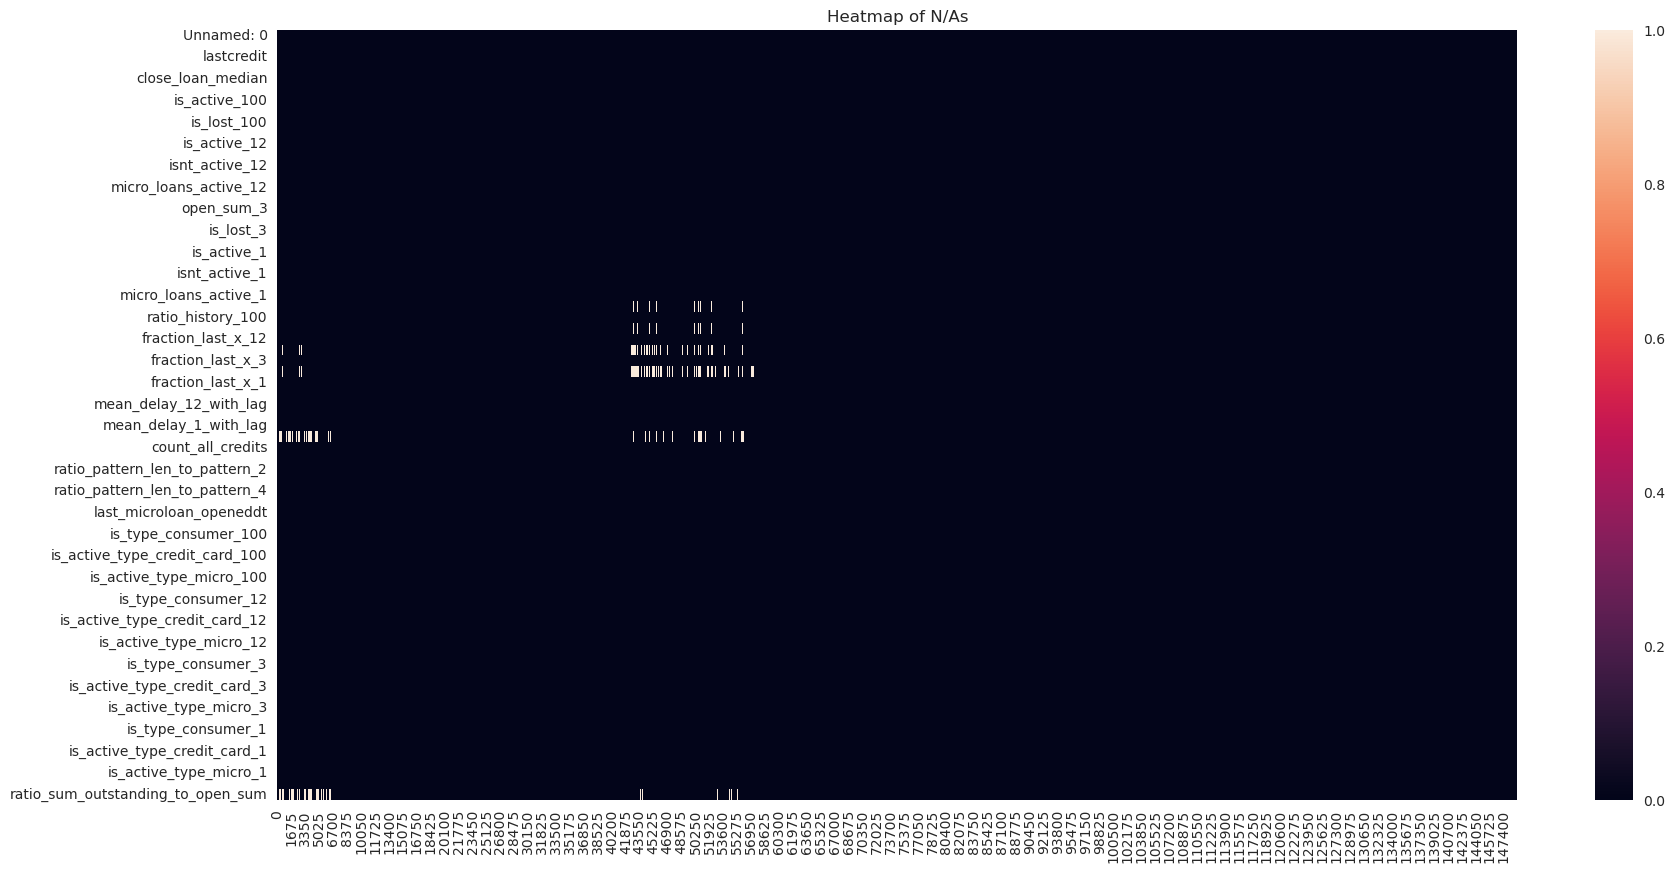

In [16]:
# generating heatmap of N/As

plt.figure(figsize=(20,10))
sns.heatmap(df.isna().T)
plt.title('Heatmap of N/As')
plt.show()

In [17]:
na_percent = df.isna().sum() / len(df) * 100
na_percent.sort_values(ascending = False).head(10)

ratio_mean_delay_3_to_12                3.666130
ratio_history_1                         2.862990
ratio_sum_outstanding_to_open_sum       2.804616
ratio_history_3                         1.745840
ratio_all_microloans_3_to_12            0.416667
ratio_history_12                        0.344874
ratio_pattern_len_to_pattern_bad_len    0.098631
ratio_pattern_len_to_pattern_3          0.098631
ratio_pattern_len_to_pattern_2          0.098631
ratio_pattern_len_to_pattern_1          0.098631
dtype: float64

The missing data seem to occur in only 2 periods of time and is probably the result of some technical issues. Most of the rows do not contain missing data. 

In [18]:
imputer = KNNImputer(n_neighbors=3)

# replace missing values with imputed values
df_imputed = imputer.fit_transform(df)

# convert the imputed array back to a dataframe
df_imputed= pd.DataFrame(df_imputed, columns=df.columns)

# reset index while keeping original indices as a column
df = df_imputed.reset_index(drop=True).copy()

## Correlation matrix

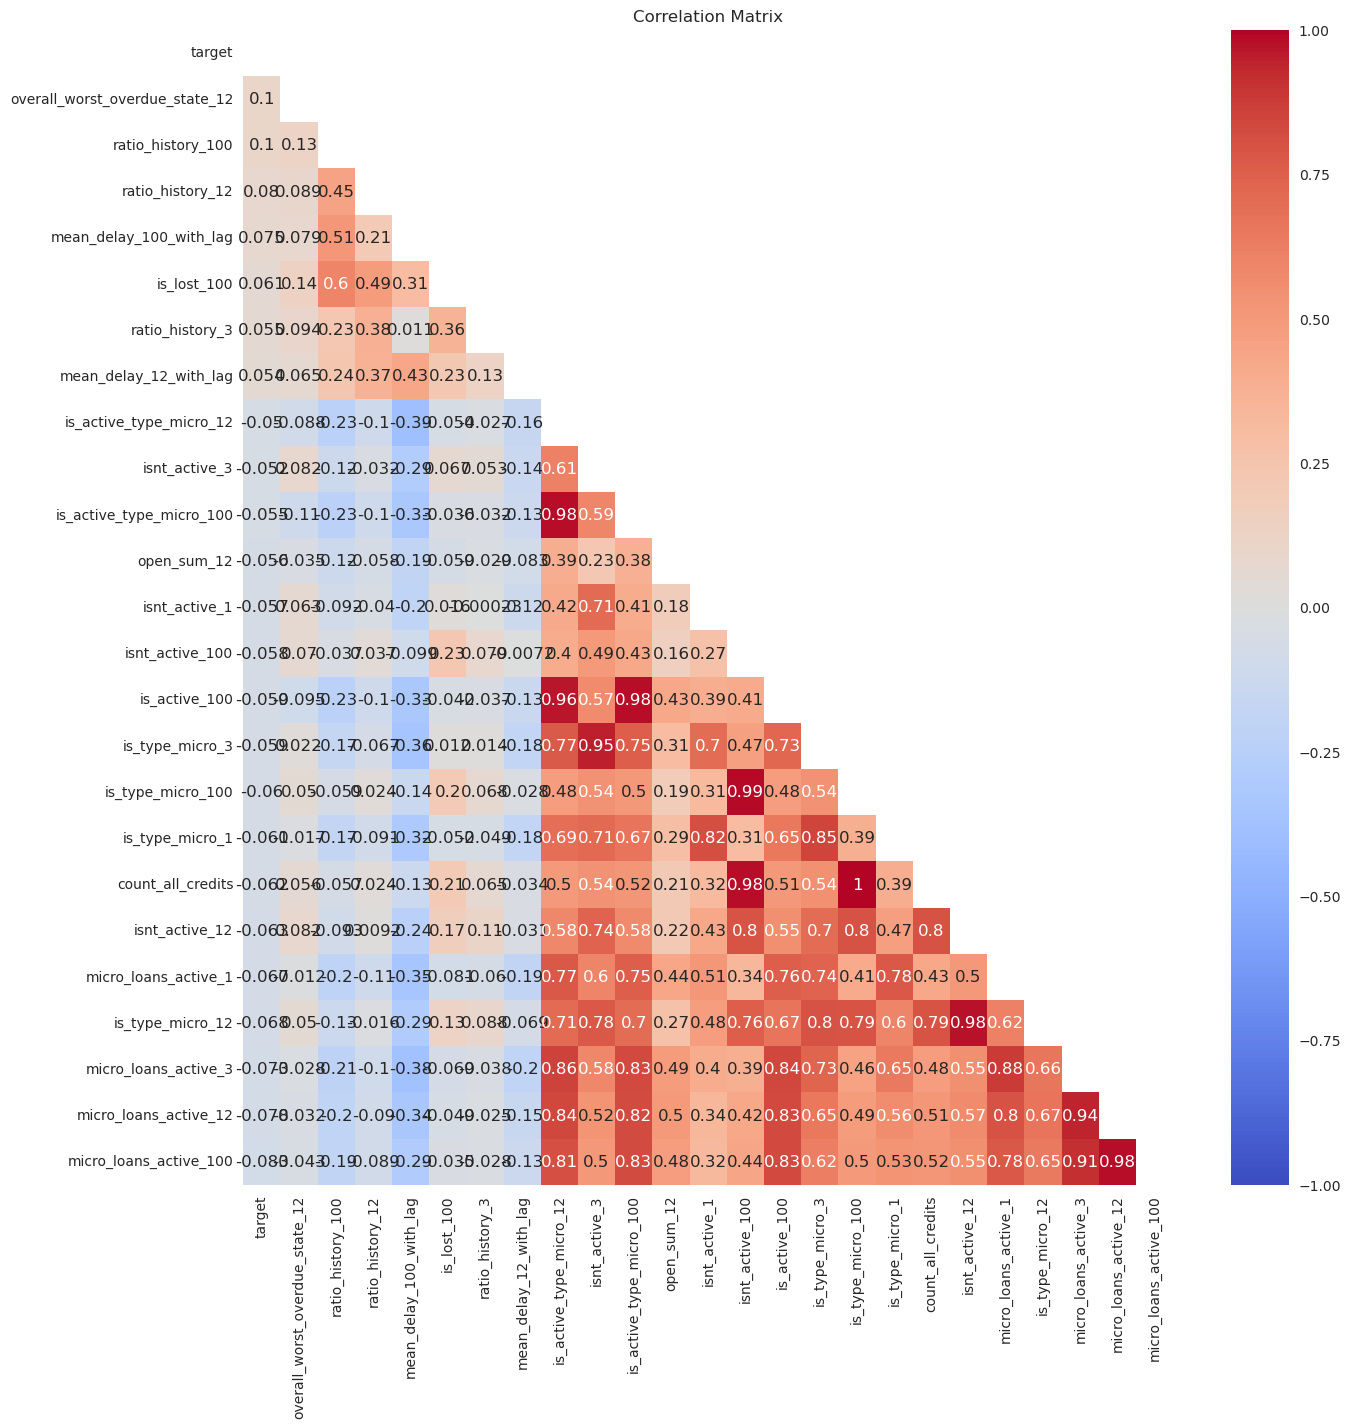

In [19]:
# Compute the correlation matrix
corr_matrix = train.corr()

# Set the correlation threshold value
corr_threshold = 0.05

# Compute the correlation between each column and the target variable
corr_matrix_target = train.corr()['target'].sort_values(ascending=False)

# Select the top correlated columns that meet the threshold criteria
high_corr_columns = corr_matrix_target[abs(corr_matrix_target) > corr_threshold].index.tolist()

# Subset the original DataFrame to include only highly correlated columns with the target variable
df_high_corr = train[high_corr_columns]

# Compute the correlation matrix for the high correlated columns
high_corr_matrix = df_high_corr.corr()

# Create a mask for the lower triangle of the array
mask = np.zeros_like(high_corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Create the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Correlation Matrix')
plt.show()

compare_multifeature_target_distribution(train, 'target', features_list)

## Handling outliers

In [20]:
# Calculate the z-scores for each data point in each column
z_scores = np.abs((df - df.mean()) / df.std())

# Identify outliers as any row with at least one z-score greater than 3
outlier_pro_col = z_scores.apply(lambda col: np.sum(col > 3), axis=0)

# Print the number of outlier values per column
print('number of outlier values per column:', '\n', outlier_pro_col.sort_values(ascending = False))

# Get a list of column names that contain outliers
cols_with_outliers = list(outlier_pro_col[outlier_pro_col > 0].index)
# Print the list of column names
print('Columns with outliers:', len(cols_with_outliers))

number of outlier values per column: 
 is_active_type_consumer_1            6534
is_type_credit_card_12               4109
ratio_history_3                      3909
is_type_credit_card_3                3829
is_active_type_credit_card_3         3682
                                     ... 
ratio_mean_delay_3_to_12                0
fraction_last_x_3                       0
fraction_last_x_12                      0
ratio_all_microloans_3_to_12            0
ratio_sum_outstanding_to_open_sum       0
Length: 71, dtype: int64
Columns with outliers: 63


In [21]:

# Calculate the z-scores of the data on the column axis
z_scores = df.apply(zscore)
# Define the limits for winsorization
lower_limit = -3
upper_limit = 3
# Compute the percentiles of the z_scores for the given limits
lower_percentile = st.norm.cdf(lower_limit)
upper_percentile = st.norm.cdf(upper_limit)

# Winsorize the outliers based on the z-scores
winsorized_data = df.copy(deep=True)
for column in winsorized_data.columns:
    outlier_mask = (z_scores[column] < lower_limit) | (z_scores[column] > upper_limit)
    column_percentiles = z_scores[column][outlier_mask].quantile([lower_percentile, upper_percentile])
    lower_quantile = column_percentiles.loc[lower_percentile]
    upper_quantile = column_percentiles.loc[upper_percentile]
    winsorized_data.loc[outlier_mask, column] = winsorized_data[column].clip(lower=lower_quantile, upper=upper_quantile)

# Print the winsorized data
winsorized_data.head()


,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
0,0.0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,4.0,36458.0,3.0,0.0,18000.0,1.0,8458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.067308,0.0,0.009615,0.0,0.000000,31.566929,8.015748,0.228346,0.228346,0.028487,127.0,0.0,0.0,0.0,0.0,0.875,289.0,1.0,2.0,115.0,1.0,1.0,32.0,1.0,1.0,5.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917
1,1.0,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,39.0,1902599.0,34.0,0.0,627578.0,33.0,583578.0,22.0,0.0,583578.0,14.0,348778.0,5.0,0.0,348778.0,0.794872,0.0,0.0,0.948052,0.0,0.714286,0.0,0.246753,0.322222,0.322222,0.000000,0.000000,0.000000,90.0,0.0,0.0,0.0,0.0,0.000,3.0,4.0,7.0,78.0,4.0,1.0,36.0,2.0,1.0,78.0,2.0,1.0,36.0,0.0,0.0,62.0,0.0,0.0,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,-0.032444
2,2.0,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,9.0,96195.0,6.0,0.0,96195.0,2.0,29156.0,0.0,0.0,29156.0,1.0,25436.0,0.0,0.0,25436.0,0.133333,0.0,0.0,0.254237,0.0,0.033898,0.0,0.016949,36.107692,18.953846,0.000000,0.000000,0.000000,65.0,0.0,0.0,0.0,0.0,0.000,19.0,3.0,2.0,60.0,3.0,1.0,21.0,0.0,0.0,15.0,0.0,0.0,9.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896
3,3.0,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,11.0,88856.0,10.0,0.0,88856.0,9.0,66856.0,0.0,0.0,66856.0,5.0,28666.0,0.0,0.0,28666.0,0.360000,0.0,0.0,0.437500,0.0,0.187500,0.0,0.104167,2.033333,1.550000,1.083333,0.000000,0.698925,60.0,0.0,0.0,0.0,0.0,0.000,14.0,2.0,0.0,58.0,2.0,0.0,11.0,0.0,0.0,25.0,0.0,0.0,11.0,0.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009
4,5.0,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,26.0,371008.0,36.0,0.0,345820.0,19.0,251720.0,5.0,0.0,251720.0,12.0,131720.0,2.0,0.0,131720.0,0.366197,0.0,0.0,0.794872,0.0,0.307692,0.0,0.179487,2.647727,0.647727,0.318182,0.000000,0.491228,88.0,0.0,0.0,0.0,0.0,0.000,5.0,0.0,2.0,86.0,0.0,1.0,25.0,0.0,1.0,71.0,0.0,1.0,25.0,0.0,0.0,26.0,0.0,0.0,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670


## Feature Engineering

In [22]:
# Set the 'open_credit' column to NaN for all rows
winsorized_data['open_credit'] = np.nan

# Replace NaN values with 1 or 0 based on the condition
winsorized_data.loc[winsorized_data['time_to_lastcredit_closeddt'] > 0, 'open_credit'] = 1
winsorized_data.loc[winsorized_data['time_to_lastcredit_closeddt'] <= 0, 'open_credit'] = 0

In [23]:
# Set the 'open_credit' column to NaN for all rows
winsorized_data['ratio_sum_outstanding_to_open_sum_negative'] = 0
winsorized_data['ratio_sum_outstanding_to_open_sum_positive'] = 0
# Replace NaN values with 1 or 0 based on the condition
winsorized_data.loc[winsorized_data['ratio_sum_outstanding_to_open_sum'] < 0, 'ratio_sum_outstanding_to_open_sum_negative'] = 1
winsorized_data.loc[winsorized_data['ratio_sum_outstanding_to_open_sum'] > 0, 'ratio_sum_outstanding_to_open_sum_positive'] = 1

#  Preprocessing and Baseline Modelling

## Creating train-validation splits

In [24]:
# Number of rows in original train set and test set
n_train = X.shape[0]
n_test = test.shape[0]

# Split data back into train and test sets
X_train = winsorized_data.iloc[:n_train, :]
X_test = winsorized_data.iloc[n_train:(n_train + n_test), :]

In [25]:
# generating train - validation splits
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y, test_size=0.2, random_state=42, stratify = y) 

In [26]:
# Concatenate the X_train and y_train datasets vertically
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

In [27]:
train_data.head(2)

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,open_sum_12,isnt_active_12,is_lost_12,micro_loans_active_12,is_active_3,open_sum_3,isnt_active_3,is_lost_3,micro_loans_active_3,is_active_1,open_sum_1,isnt_active_1,is_lost_1,micro_loans_active_1,ratio_all_microloans_3_to_12,ratio_history_100,ratio_history_12,fraction_last_x_12,ratio_history_3,fraction_last_x_3,ratio_history_1,fraction_last_x_1,mean_delay_100_with_lag,mean_delay_12_with_lag,mean_delay_3_with_lag,mean_delay_1_with_lag,ratio_mean_delay_3_to_12,count_all_credits,ratio_pattern_len_to_pattern_1,ratio_pattern_len_to_pattern_2,ratio_pattern_len_to_pattern_3,ratio_pattern_len_to_pattern_4,ratio_pattern_len_to_pattern_bad_len,last_microloan_openeddt,is_type_credit_card_100,is_type_consumer_100,is_type_micro_100,is_active_type_credit_card_100,is_active_type_consumer_100,is_active_type_micro_100,is_type_credit_card_12,is_type_consumer_12,is_type_micro_12,is_active_type_credit_card_12,is_active_type_consumer_12,is_active_type_micro_12,is_type_credit_card_3,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,open_credit,ratio_sum_outstanding_to_open_sum_negative,ratio_sum_outstanding_to_open_sum_positive,target
34500,27656.0,24.0,5.0,0.0,0.0,0.0,34.0,89.0,1.0,368600.0,34.0,555600.0,89.0,1.0,368600.0,30.0,366600.0,23.713301,1.0,356600.0,24.0,273400.0,6.0,0.0,273400.0,0.775362,0.00813,0.00813,1.000000,0.010417,0.780488,0.0,0.243902,0.000000,0.000000,0.000000,0.0,0.000000,141.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,1.0,138.0,2.0,1.0,31.0,2.0,1.0,138.0,2.0,1.0,31.0,0.0,1.0,18.743625,0.0,1.0,29.0,0.0,0.0,34.0,0.0,0.0,24.0,120.0,0.038427,0.0,0,1,1
20663,13819.0,23.0,1.0,0.0,0.0,4.0,8.0,45.0,0.0,45560.0,8.0,45560.0,34.0,0.0,45560.0,7.0,40560.0,11.000000,0.0,40560.0,6.0,35180.0,4.0,0.0,35180.0,0.420000,0.00000,0.00000,0.792453,0.000000,0.339623,0.0,0.188679,10.920635,9.984127,2.920635,0.0,0.292528,63.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,62.0,0.0,0.0,8.0,0.0,0.0,50.0,0.0,0.0,8.0,0.0,0.0,21.000000,0.0,0.0,7.0,0.0,0.0,12.0,0.0,0.0,6.0,120.0,0.109745,0.0,0,1,0


## Baseline Models from PyCaret

In [68]:
import re
# Replace special characters in feature names
train_data.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in train_data.columns]
val_data.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in val_data.columns]
X_test.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in X_test.columns]

In [30]:
# Create a PyCaret experiment with the train and validation sets
exp_clf = setup(data=train_data, target='target', session_id=42, fold = 3, 
                test_data = val_data,  normalize = True, normalize_method='minmax', 
                categorical_features = [ 'open_credit',
                            'ratio_sum_outstanding_to_open_sum_negative', 
                            'ratio_sum_outstanding_to_open_sum_positive'],
                ignore_features = [], 
                remove_multicollinearity = True,
                multicollinearity_threshold = 0.9,
                 data_split_stratify = True, 
                feature_selection = True ,n_features_to_select = 0.8,
                feature_selection_method='classic', #univariate
                feature_selection_estimator = 'lightgbm', fix_imbalance=True, fix_imbalance_method = 'AllKNN')

# Compare multiple classifiers using 3-fold cross-validation
best_model = compare_models(fold=3, round=3, sort='AUC') #, include = #'xgboost', 'catboost', 'rf', 'knn', [, 'xgboost']

,Description,Value
0,Session id,42
1,Target,target
2,Target type,Binary
3,Original data shape,"(42529, 75)"
4,Transformed data shape,"(24886, 60)"
5,Transformed train set shape,"(16380, 60)"
6,Transformed test set shape,"(8506, 60)"
7,Ordinal features,3
8,Numeric features,71
9,Categorical features,3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.493,0.641,0.798,0.329,0.466,0.121,0.166,10.497
lightgbm,Light Gradient Boosting Machine,0.494,0.640,0.795,0.329,0.466,0.121,0.165,1.800
gbc,Gradient Boosting Classifier,0.468,0.635,0.828,0.322,0.463,0.106,0.156,9.020
rf,Random Forest Classifier,0.494,0.629,0.775,0.326,0.459,0.113,0.152,6.053
et,Extra Trees Classifier,0.487,0.625,0.782,0.324,0.458,0.109,0.148,4.320
xgboost,Extreme Gradient Boosting,0.503,0.625,0.757,0.328,0.458,0.116,0.152,7.233
ada,Ada Boost Classifier,0.487,0.621,0.777,0.324,0.457,0.107,0.146,3.080
lda,Linear Discriminant Analysis,0.468,0.621,0.797,0.317,0.454,0.095,0.135,1.050
lr,Logistic Regression,0.466,0.620,0.798,0.317,0.453,0.093,0.133,16.853
qda,Quadratic Discriminant Analysis,0.705,0.598,0.158,0.418,0.229,0.091,0.107,0.957


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

#  Hyperparameter tuning and evaluating

In [ ]:
# Compute class weights based on inverse frequency

class_weights = compute_class_weight(class_weight='balanced', classes=train_data['target'].unique(), y=train_data['target'])

# Set the positive class weight and negative class weight
pos_weight = class_weights[0] / class_weights[1] * .2
neg_weight = class_weights[1] / class_weights[0]

In [63]:
# Create a CatBoost classifier
custom_catboost = CatBoostClassifier( verbose=0)
# define the parameter grid to search over
params = {
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [2, 3, 5, 7],
    'iterations': [50, 100, 200],
    'l2_leaf_reg': [1, 3, 5]
}

# tune the CatBoost classifier with adjusted class weights
tuned_catboost = tune_model(custom_catboost, optimize='F1', fold=5, n_iter=20, custom_grid=params)

# evaluate the tuned CatBoost classifier
evaluate_model(tuned_catboost)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5105,0.6433,0.7828,0.3360,0.4702,0.1339,0.1768
1,0.4970,0.6505,0.8056,0.3323,0.4705,0.1280,0.1757
2,0.5017,0.6539,0.8046,0.3345,0.4725,0.1326,0.1805
3,0.4912,0.6435,0.8030,0.3291,0.4669,0.1208,0.1670
4,0.4949,0.6330,0.8088,0.3317,0.4705,0.1269,0.1752
Mean,0.4990,0.6448,0.8010,0.3327,0.4701,0.1284,0.1750
Std,0.0067,0.0072,0.0093,0.0024,0.0018,0.0046,0.0044


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [62]:
# Create an XGBClassifier 
custom_xgb = XGBClassifier() 
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
}
# Train the XGBClassifier with custom param grid
tuned_xgb = tune_model(custom_xgb, optimize='F1', fold=5, n_iter=20, custom_grid=param_grid)

# Evaluate the tuned XGBClassifier
evaluate_model(tuned_xgb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4957,0.6380,0.7855,0.3288,0.4636,0.1190,0.1609
1,0.4945,0.6527,0.8093,0.3316,0.4704,0.1267,0.1752
2,0.4977,0.6548,0.8093,0.3332,0.4720,0.1301,0.1790
3,0.4919,0.6445,0.8194,0.3318,0.4723,0.1277,0.1789
4,0.4865,0.6377,0.8035,0.3269,0.4648,0.1161,0.1617
Mean,0.4933,0.6455,0.8054,0.3305,0.4686,0.1239,0.1711
Std,0.0039,0.0072,0.0112,0.0023,0.0037,0.0054,0.0081


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [51]:
# Create an LGBMClassifier
custom_lightgbm = LGBMClassifier() 
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 3, 5, 7],
    'min_child_samples': [1, 5, 10, 20],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    'n_estimators': [100, 500, 1000]
}
# Train the XGBClassifier 
tuned_lightgbm = tune_model(custom_lightgbm, optimize='F1', fold=5, n_iter=20, custom_grid=params, verbose = True)

# Evaluate the tuned XGBClassifier
evaluate_model(tuned_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5080,0.6427,0.7765,0.3338,0.4669,0.1288,0.1698
1,0.5012,0.6480,0.7977,0.3333,0.4702,0.1295,0.1754
2,0.4996,0.6501,0.7971,0.3324,0.4692,0.1276,0.1732
3,0.4954,0.6436,0.8120,0.3325,0.4718,0.1287,0.1781
4,0.4984,0.6397,0.8019,0.3325,0.4701,0.1281,0.1748
Mean,0.5005,0.6448,0.7970,0.3329,0.4696,0.1285,0.1743
Std,0.0042,0.0037,0.0116,0.0005,0.0016,0.0007,0.0027


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Submission and suggestions for improvement

We will make the final prediction using catboost, since it seems slighly more robust in terms of standard deviation and is likely to be a bit better on the test set.

However the LGBMClassifier and XGBClassifier have not been significantly worse.

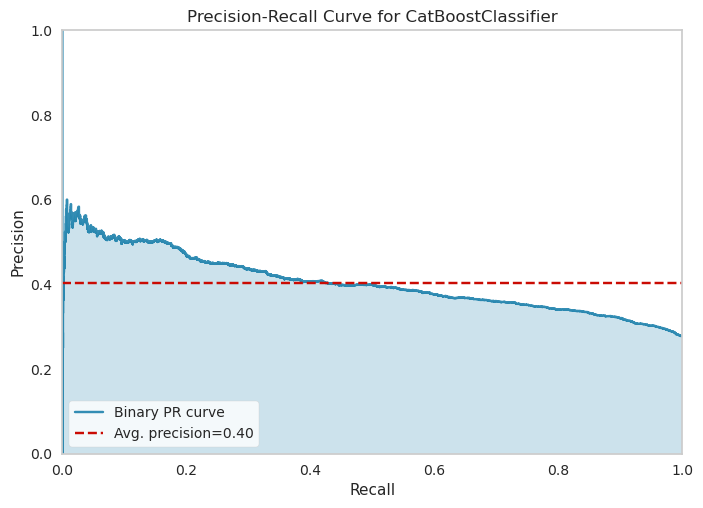

In [75]:
plot_model(tuned_catboost, 'pr')

It is notworthly that with the existing model we may get a nearly perfect recall if we sacrifice the precision slighly. 

In [65]:
# finalizing model 
final_model = finalize_model(tuned_catboost)

In [77]:
predictions = predict_model(final_model, data = X_test)
# reset index to a column
submission = predictions.reset_index()
# rename columns
submission = submission.rename(columns={'index': 'id', 'prediction_label':'target'})
submission[['id', 'target']].to_csv('output1.csv',index=False)

With the help of existing feature space and without significant feature engineering we managed to achieve the result that is close to the requested score.

For improving the result we might collect information from external data sources that can provide additional information about the clients such as credit scores.

Further client characteristics such as gender, education, income and employment status might be good predictive features.

We can use more sophisticated feature engineering techniques to create new features that capture important information about the clients. For example, we can create a feature that calculates the average time between loan applications to capture the frequency of borrowing. We can also create a feature that measures the anomalies in client behaviour, i.e. applying for a loan of an unusual amount. 

We can also explore different strategies such as oversampling the minority class or using cost-sensitive learning to balance the performance of the model on different classes.

Finally we can try out different modeling techniques such as ensemble methods, deep learning, and anomaly detection to improve the performance of the model. More robust hyperparameter tuning can also improve the performance.
